### 3.1 线性回归

##### 3.1.1 线性回归的基本要素
* 模型定义
* 模型训练
    - 训练数据
    - 损失函数
    - 优化算法
* 模型预测

##### 3.1.2 线性回归的表示方法
* 神经网络图
* 矢量计算表达式

### 3.2 线性回归从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

##### 3.2.1 生成数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(
    np.random.normal(0, 1, (num_examples, num_inputs)),
    dtype=torch.float)
labels = (true_w[0] * features[:, 0] + 
          true_w[1] * features[:, 1] + 
          true_b)
labels += torch.from_numpy(np.random.normal(
    0, 0.01, size=labels.size()))

In [3]:
print(features[0], labels[0])

tensor([0.3108, 1.0947]) tensor(1.0886)


In [4]:
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

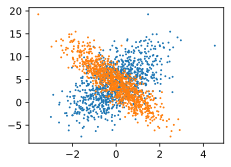

In [5]:
set_figsize()
plt.scatter(features[:,0].numpy(), labels.numpy(), 1)
plt.scatter(features[:,1].numpy(), labels.numpy(), 1)

##### 3.2.2 读取数据

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(
            indices[i:min(i + batch_size, num_examples)])
        yield (features.index_select(0, j), 
               labels.index_select(0, j))

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-1.1253,  0.0807],
        [ 0.4860,  0.2448],
        [-0.7278, -0.4281],
        [-0.7885, -0.7160],
        [-0.0255, -0.9074],
        [-0.7332, -1.0645],
        [-1.8495, -0.9361],
        [ 0.3961, -0.1149],
        [ 0.1134, -0.9970],
        [-1.1392,  0.1894]]) tensor([1.6650, 4.3419, 4.2102, 5.0802, 7.2511, 6.3495, 3.6802, 5.3955, 7.8102,
        1.2938])


##### 3.2.3 初始化模型参数

In [8]:
w = torch.tensor(
    np.random.normal(0, 0.01, (num_inputs, 1)),
    dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

##### 3.2.4 定义模型

In [9]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

##### 3.2.5 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

##### 3.2.6 定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    #print("sgd, lr %f, batch_size, %d" % 
    #      (lr, batch_size))
    for param in params:
        param.data -= lr * param.grad / batch_size

##### 3.2.7  训练模型

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_1 = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % 
          (epoch + 1, train_1.mean().item()))

epoch 1, loss 0.034485
epoch 2, loss 0.000123
epoch 3, loss 0.000049


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0000],
        [-3.3998]], requires_grad=True)
4.2 
 tensor([4.1998], requires_grad=True)


### 3.3 线性回归的简洁实现

In [14]:
# 读取数据
import torch.utils.data as Data
batch_size = 10
dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(
    dataset, batch_size, shuffle=True)

In [15]:
# 定义模型
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    def forward(self, x):
        y = self.linear(x)
        return y

In [16]:
net = LinearNet(num_inputs)
print(net)
#print(net[0])

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [17]:
# 还可以用nn.Sequential来更方便的搭建网络
# Sequential是一个有序的容器，
# 网络层将按照传入的顺序依次加入到计算图中

# 写法一
net1 = nn.Sequential(
    nn.Linear(num_inputs, 1)
)

# 写法二
net2 = nn.Sequential()
net2.add_module('linear', nn.Linear(num_inputs, 1))

# 写法三
from collections import OrderedDict
net3 = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
]))

In [18]:
print(net1)
print(net2)
print(net3)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [19]:
print(net1[0])
print(net2[0])

Linear(in_features=2, out_features=1, bias=True)
Linear(in_features=2, out_features=1, bias=True)


In [20]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.6215, 0.5234]], requires_grad=True)
Parameter containing:
tensor([0.5733], requires_grad=True)


In [21]:
# 初始化模型参数
from torch.nn import init
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)
# 也可以直接修改bias的data
# net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

In [22]:
# 定义损失函数
loss = nn.MSELoss()

In [23]:
# 定义优化算法
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=lr)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [24]:
# 训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        # 梯度清零，等介于
        # net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000124
epoch 2, loss: 0.000118
epoch 3, loss: 0.000083


In [25]:
print(true_w, net.linear.weight)
print(true_b, net.linear.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9999, -3.4000]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2015], requires_grad=True)


### 3.4 Softmax回归

* 分类问题
* Softmax回归模型
* 单样本分类的矢量计算表达式
* 小批量样本分类的矢量计算表达式
* 交叉熵损失函数
* 模型预测及评价

### 3.5 图像分类数据集 Fashion-MNIST

In [26]:
# 获取数据集
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys

In [27]:
mnist_data_path = '~/Datasets/FashionMNIST'
mnist_train = torchvision.datasets.FashionMNIST(
    root=mnist_data_path,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
mnist_test = torchvision.datasets.FashionMNIST(
    root=mnist_data_path,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [28]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [29]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


In [30]:
def get_fashion_mnist_labels(labels):
    text_labels = [
        't-shirt',
        'trouser',
        'pullover',
        'dress',
        'coat',
        'sandal',
        'shirt',
        'sneaker',
        'bag',
        'ankle boot',
    ]
    return [text_labels[int(i)] for i in labels]

In [31]:
def show_fashion_mnist(images, labels):
    use_svg_display()
    _, figs = plt.subplots(1, len(images), 
                           figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

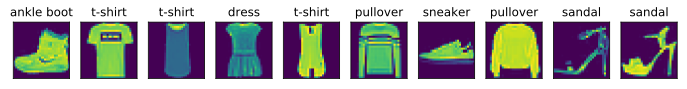

In [32]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [33]:
# 读取小批量
def load_data_fashion_mnist(batch_size=256):
    '''
    if sys.platform.startswith('win'):
        num_workers = 0
    else:
        num_workers = 4
    '''
    num_workers = 0
    train_iter = torch.utils.data.DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_iter = torch.utils.data.DataLoader(
        mnist_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_iter, test_iter

In [34]:
train_iter, test_iter = load_data_fashion_mnist()

In [35]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

5.89 sec


### 3.6 Softmax回归的从零开始实现

In [36]:
import torch
import torchvision
import numpy as np
import sys

In [37]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size)

In [38]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(
    np.random.normal(0, 0.01, (num_inputs, num_outputs)),
    dtype=torch.float
)
b = torch.zeros(num_outputs, dtype=torch.float)

In [39]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [40]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

In [41]:
def net(X):
    return softmax(torch.mm(
        X.view((-1, num_inputs)), W) + b)

In [42]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))

In [43]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y
           ).float().mean().item()

In [44]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc = (net(X).argmax(dim=1) == y)
        acc_sum += acc.float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [45]:
def train_ch3(net, train_iter, test_iter, loss,
             num_epochs, batch_size, params=None,
             lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif (params is not None and 
                  params[0].grad is not None):
                for param in params:
                    param.grad.data.zero_()
                    
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y
                             ).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f' % 
              (epoch + 1, train_l_sum / n)) 
        print('train acc %.3f, test acc %.3f' % 
              (train_acc_sum / n, test_acc))       

In [46]:
num_epochs, lr = 5, 0.1
train_ch3(net, train_iter, test_iter, cross_entropy, 
         num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7852
train acc 0.750, test acc 0.793
epoch 2, loss 0.5707
train acc 0.814, test acc 0.812
epoch 3, loss 0.5252
train acc 0.825, test acc 0.813
epoch 4, loss 0.5012
train acc 0.832, test acc 0.822
epoch 5, loss 0.4856
train acc 0.836, test acc 0.827


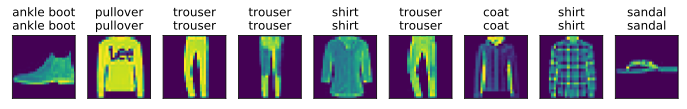

In [47]:
X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(
    net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(
    true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

### 3.7 Softmax回归的简洁实现

In [48]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys

In [49]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size)

In [50]:
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): 
        # x shape: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y

In [51]:
num_inputs = 784
num_outputs = 10
net = LinearNet(num_inputs, num_outputs)

In [52]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

In [53]:
from collections import OrderedDict
net = nn.Sequential(
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ]))

In [54]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [55]:
loss = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [56]:
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs,
         batch_size, None, None, optimizer)

epoch 1, loss 0.0031
train acc 0.749, test acc 0.791
epoch 2, loss 0.0022
train acc 0.813, test acc 0.799
epoch 3, loss 0.0021
train acc 0.825, test acc 0.817
epoch 4, loss 0.0020
train acc 0.832, test acc 0.789
epoch 5, loss 0.0019
train acc 0.836, test acc 0.824


### 3.8 多层感知机

##### 3.8.1 隐藏层

##### 3.8.2 激活函数

In [57]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.detach().numpy(),
            y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

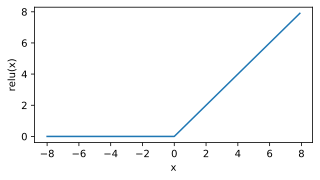

In [58]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

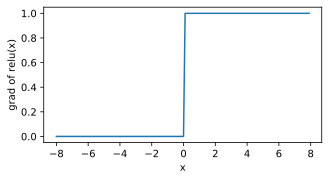

In [59]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

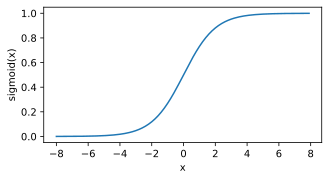

In [60]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

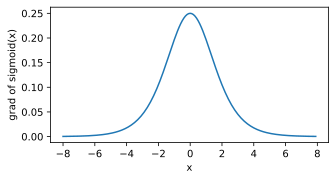

In [61]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

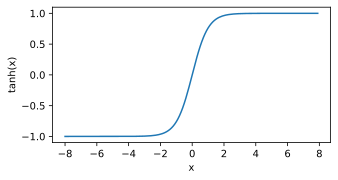

In [62]:
y = x.tanh()
xyplot(x, y, 'tanh')

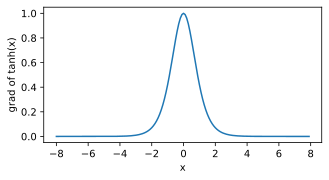

In [63]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

### 3.9 多层感知机从零开始实现



In [64]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size)

In [65]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(
    np.random.normal(0, 0.01, (num_inputs, num_hiddens)),
    dtype=torch.float
)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(
    np.random.normal(0, 0.01, (num_hiddens, num_outputs)),
    dtype=torch.float
)
b2 = torch.zeros(num_outputs, dtype=torch.float)
params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [66]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

In [67]:
def net(X):
    X = X.view(-1, num_inputs)
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

In [68]:
loss = torch.nn.CrossEntropyLoss()

In [69]:
num_epochs, lr = 5, 100.0
train_ch3(net, train_iter, test_iter, loss, num_epochs,
         batch_size, params, lr)

epoch 1, loss 0.0030
train acc 0.714, test acc 0.777
epoch 2, loss 0.0019
train acc 0.823, test acc 0.823
epoch 3, loss 0.0017
train acc 0.844, test acc 0.828
epoch 4, loss 0.0015
train acc 0.856, test acc 0.846
epoch 5, loss 0.0015
train acc 0.864, test acc 0.832


### 3.10 多层感知机的简洁实现

In [71]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
)
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

In [72]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs,
         batch_size, None, None, optimizer)

epoch 1, loss 0.0033
train acc 0.686, test acc 0.765
epoch 2, loss 0.0019
train acc 0.817, test acc 0.823
epoch 3, loss 0.0017
train acc 0.841, test acc 0.767
epoch 4, loss 0.0015
train acc 0.855, test acc 0.797
epoch 5, loss 0.0014
train acc 0.864, test acc 0.848


### 3.11 模型选择，欠拟合和过拟合
* 训练误差，泛化误差
* 模型选择
    - 验证数据集
    - K-fold cross-validation
* 欠拟合和过拟合
    - 模型复杂度
    - 训练数据集大小

##### 3.11.4 多项式函数拟合实验

In [74]:
# y = 1.2 * x - 3.4 * x * x + 5.6 * x * x * x + 5 + epslon

In [75]:
n_train, n_test = 100, 100
true_w, true_b = [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat(
    (features, 
     torch.pow(features, 2), 
     torch.pow(features, 3)), 
    1)
labels = (true_w[0] * poly_features[:, 0] +
         true_w[1] * poly_features[:, 1] +
         true_w[2] * poly_features[:, 2] +
         true_b) 
labels += torch.tensor(
    np.random.normal(0, 0.001, size=labels.size()),
    dtype=torch.float)

In [76]:
features[:2], poly_features[:2], labels[:2]

(tensor([[1.2400],
         [0.6470]]), tensor([[1.2400, 1.5375, 1.9065],
         [0.6470, 0.4187, 0.2709]]), tensor([11.9365,  5.8690]))

In [89]:
def semilogy(x_vals, y_vals, x_labels, y_labels, 
            x2_vals=None, y2_vals=None, legend=None,
            figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_labels)
    plt.ylabel(y_labels)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [124]:
num_epochs, loss = 500, torch.nn.MSELoss()

In [125]:
def fit_and_plot(train_features, test_features, 
                 train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(
        train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), 
                                lr=0.005)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(
            net(train_features), train_labels).item())
        test_ls.append(loss(
            net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1],
         'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 
            'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, 
            ['train', 'test'])
    print('weight:', net.weight.data, 
         '\nbias:', net.bias.data)

final epoch: train loss 1.0359214002164663e-06 test loss 9.605433888282278e-07
weight: tensor([[ 1.1999, -3.3999,  5.6001]]) 
bias: tensor([4.9998])


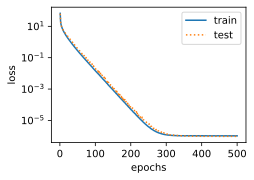

In [126]:
fit_and_plot(poly_features[:n_train, :], 
             poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

final epoch: train loss 363.5419616699219 test loss 191.47698974609375
weight: tensor([[18.8084]]) 
bias: tensor([1.1454])


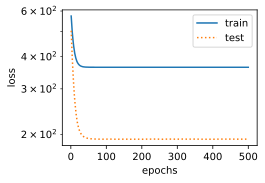

In [127]:
fit_and_plot(features[:n_train, :], 
             features[n_train:, :],
            labels[:n_train], labels[n_train:])

final epoch: train loss 115.57745361328125 test loss 109.61541748046875
weight: tensor([[ 12.9502, -13.3385]]) 
bias: tensor([10.7660])


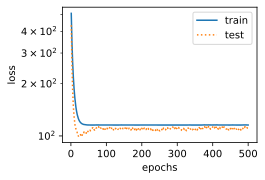

In [130]:
fit_and_plot(poly_features[:n_train, :2], 
             poly_features[n_train:, :2],
            labels[:n_train], labels[n_train:])

final epoch: train loss 0.0655519887804985 test loss 347.2535400390625
weight: tensor([[2.0710, 1.8701, 1.9641]]) 
bias: tensor([2.8746])


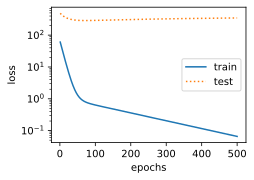

In [131]:
fit_and_plot(poly_features[0:2, :], 
            poly_features[n_train:, :],
            labels[0:2],
            labels[n_train:])

### 3.12 权重衰减
* 权重衰减等价于L2范数正则化

In [132]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(
    0, 0.01, size=labels.size()), dtype=torch.float)
train_features = features[:n_train, :]
test_features = features[n_train:, :]
train_labels = labels[:n_train]
test_labels = labels[n_train:]

In [133]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [134]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [137]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linreg, squared_loss
dataset = torch.utils.data.TensorDataset(train_features,
                                        train_labels)
train_iter = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        shuffle=True)

In [150]:
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = (loss(net(X, w, b), y) + 
                 lambd * l2_penalty(w))
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), 
                             train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b),
                           test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs',
            'loss', range(1, num_epochs + 1), test_ls,
            ['train', 'test'])
    print('L2 norm of w:', w.norm().item())
    print(w[:10], b)

L2 norm of w: 13.191913604736328
tensor([[ 0.1404],
        [ 0.2117],
        [ 0.3878],
        [ 0.1952],
        [-0.7876],
        [-0.2761],
        [ 0.9220],
        [-1.2316],
        [-1.0632],
        [ 0.2561]], grad_fn=<SliceBackward>) tensor([0.0405], requires_grad=True)


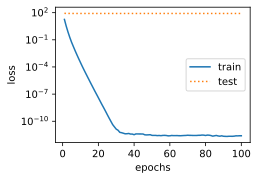

In [151]:
fit_and_plot(lambd=0)

L2 norm of w: 0.03269898146390915
tensor([[ 2.9789e-04],
        [-2.6031e-03],
        [ 3.7843e-03],
        [-2.4501e-03],
        [ 4.3559e-06],
        [ 2.1874e-03],
        [ 2.1248e-03],
        [ 5.3721e-04],
        [ 6.9536e-03],
        [ 2.7766e-03]], grad_fn=<SliceBackward>) tensor([0.0341], requires_grad=True)


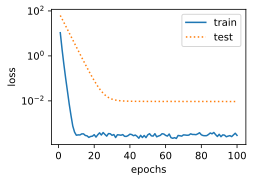

In [152]:
fit_and_plot(lambd=3)

In [159]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(
        params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(
        params=[net.bias], lr=lr)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),
                            train_labels).mean().item())
        test_ls.append(loss(net(test_features),
                           test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs',
            'loss', range(1, num_epochs + 1), test_ls, 
            ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())
    print(net.weight.data[:, :10], net.bias.data)

L2 norm of w: 13.774930000305176
tensor([[ 0.6673,  0.8674,  0.7253, -1.4877, -0.6067, -1.3256, -0.5311, -0.6136,
         -0.0511, -1.6171]]) tensor([1.6628])


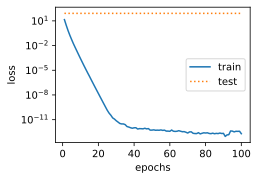

In [160]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.08996311575174332
tensor([[ 7.8906e-05, -4.6049e-03,  3.7547e-03,  6.0516e-03,  2.2276e-03,
         -1.1659e-03, -8.3404e-03,  8.7588e-03,  1.1022e-02,  9.5344e-04]]) tensor([0.3378])


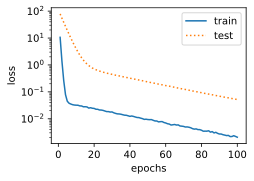

In [161]:
fit_and_plot_pytorch(3)

### 3.13 丢弃法 Dropout

In [196]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.randn(X.shape) < keep_prob).float()
    return mask * X / keep_prob

In [206]:
X = torch.arange(16).view(2, 8)
dropout(X, 0.0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [207]:
dropout(X, 0.5)

tensor([[ 0.,  2.,  4.,  0.,  0., 10., 12., 14.],
        [16.,  0., 20., 22., 24., 26., 28., 30.]])

In [208]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [209]:
print(X.float())

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])


In [210]:
torch.nn.functional.dropout(X.float(), 0.5, True, False)

tensor([[ 0.,  2.,  0.,  0.,  0., 10.,  0.,  0.],
        [16., 18.,  0.,  0.,  0.,  0.,  0., 30.]])

In [220]:
num_inputs, num_outputs = 784, 10
num_hiddens1, num_hiddens2 = 256, 256
W1 = torch.tensor(np.random.normal(
    0, 0.01, size=(num_inputs, num_hiddens1)),
                 dtype=torch.float, 
                 requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(
    0, 0.01, size=(num_hiddens1, num_hiddens2)),
                 dtype=torch.float,
                 requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(
    0, 0.01, size=(num_hiddens2, num_outputs)),
                 dtype=torch.float,
                 requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

In [221]:
drop_prob1, drop_prob2 = 0.2, 0.5
def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training: 
        H1 = dropout(H1, drop_prob1)
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3) + b3

In [224]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y
                       ).float().sum().item()
            net.train()
        else:
            if 'is_training' in net.__code__.co_varnames:
                acc_sum += (net(X, is_training=False)
                           .argmax(dim=1) == y
                           ).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1) == y
                           ).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [225]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(
    batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs,
         batch_size, params, lr)

epoch 1, loss 0.0022
train acc 0.792, test acc 0.829
epoch 2, loss 0.0018
train acc 0.827, test acc 0.828
epoch 3, loss 0.0017
train acc 0.844, test acc 0.835
epoch 4, loss 0.0016
train acc 0.853, test acc 0.828
epoch 5, loss 0.0015
train acc 0.860, test acc 0.847


In [226]:
# 简洁实现
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2, num_outputs)
)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [227]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
train_ch3(net, train_iter, test_iter, loss, num_epochs,
         batch_size, None, None, optimizer)

epoch 1, loss 0.0046
train acc 0.547, test acc 0.764
epoch 2, loss 0.0023
train acc 0.782, test acc 0.778
epoch 3, loss 0.0019
train acc 0.820, test acc 0.791
epoch 4, loss 0.0018
train acc 0.836, test acc 0.801
epoch 5, loss 0.0016
train acc 0.848, test acc 0.842


### 3.14 正向传播，反向传播和计算图
* 正向传播
* 正向传播的计算图
* 反向传播
* 训练深度学习模型

### 3.15 数值稳定性和模型初始化
* 衰减和爆炸
* 随机初始化模型参数
    - Pytorch默认随机初始化
        - nn.Module模块参数都采取了较为合理的初始化策略
    - Xavier初始化

### 3.16 实战kaggle比赛：房价预测